In [1]:
from init_plot import *

2024-09-15 15:56:23.513617: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[func help]----------------------------------------------------------------
> parameter
    p_root	[name] res_publish
        p_run, p_plot, p_res, p_cache, p_pdf
    p_df_varmap
    map_sp_reverse
    rng
[from func import * ]------------------------------------------------------
| p_root                  | display              | get_res_obs               |
| p_run                   | h5ad_to_mtx          | get_source_obs            |
| p_plot                  | load_adata           | get_matrix_max_prob_median|
| p_res                   | load_normalized_adata| get_matrix_count          |
| p_cache                 | pdf2_merge           | get_path_varmap           |
| p_pdf                   | show_umap            | get_res_stat              |
| p_data_process          | time_tag_detect      | find_path_from_para       |
| map_sp                  | time_tag_get         | func_help                 |
| map_sp_reverse          | time_tag_toggle      |                           |
| map_s

In [2]:
item = 'Mtb_COVID'
model = 'csMAHN'
if sys.argv[1] == 'True':
    model = sys.argv[2]
assert model in 'Seurat,came,csMAHN,SAMap'.split(
    ','), '[Error] Invalid modle "{}"'.format(model)

# Mtb

In [3]:
with Block("""ppara_data
    para_Mtb
    res_Mtb
""", context=dict(item='Mtb')) as context:
    data = pd.read_csv(p_cache.joinpath(
        'parameter_{}.csv'.format(context.item)
    ))
    data['path_ref'] = data['path_ref'].apply(
        lambda x: p_cache.joinpath(x))
    data['path_que'] = data['path_que'].apply(
        lambda x: p_cache.joinpath(x))
    ppara_data['para_Mtb'] = data
    del data
    
    data = get_test_result_df(p_res)
    data = data.query("tissue == '{}'".format(context.item))
    data = data.loc[data['name'].str.extract(
        ';(\\d{6}-\\d{4})$', expand=False).fillna('').str.len() == 0, :]
    data['__index'] = ut.df.apply_merge_field(
        data, '{tissue};{sp_ref}{sp_que};{name_que};{model}')
    data = ut.df.reindex_with_unique_col(data, '__index')
    ppara_data['res_Mtb'] = data
    del data


[extract]
^(?P<tissue>.+)_(?P<sp_ref>.+)-corss-(?P<sp_que>.+);(?P<model>came|csMAHN|Seurat|SAMap);(?P<name_ref>[\w-]+)-map-(?P<name_que>[[\w-]+);?(?P<resdir_tag>.+)?$


/public/workspace/licanchengup/apps/miniconda3/envs/publish/lib/python3.9/site-packages/pandas/core/strings/accessor.py:2738: FutureWarning: Possible nested set at position 127
  regex = re.compile(pat, flags=flags)


In [4]:
with Block("ppara_adata['Mtb_mh']"):
    ppara_adata['Mtb_mh'] = get_adata_umap(
        ppara_data['res_Mtb'].loc['Mtb;mh;Mtb-h-macr;{}'.format(model), :]
    )
    ppara_adata['Mtb_mh'].obs['sp'] = ppara_adata['Mtb_mh']\
        .obs['sp'].map(map_sp)

    data = ppara_adata['Mtb_mh'].obs
    # 过滤掉 human 中的AM_IM1(162) 与 AM_MT(49)
    # display(data['preobs_sub_cell_type'].value_counts())
    data = data.query("(dataset_type == 'ref')  | \
    ((dataset_type == 'que') & (preobs_sub_cell_type != 'AM_IM1') & (preobs_sub_cell_type != 'AM_MT') )").copy()

    data['preobs_sub_cell_type'] = data['preobs_sub_cell_type'].mask(
        data['preobs_sub_cell_type'] == 'AM_2_exclusive', 'AM_2'
    )
    data['model_label'] = ''
    data['model_label'] = data['model_label']\
        .mask(data['dataset_type'] == 'ref', data['true_label'])\
        .mask(data['dataset_type'] == 'que', data['pre_label'])
    
    # 将IM1-4 合为IMs
    data['pre_label_1'] = data['pre_label']
    data['pre_label'] = data['pre_label'].mask(
        data['pre_label'].str.startswith('IM_'), 'IMs')
    data['true_label_1'] = data['true_label']
    data['true_label'] = data['true_label'].mask(
        data['true_label'].str.startswith('IM_'), 'IMs')
    data['model_label_1'] = ''
    data['model_label_1'] = data['model_label_1']\
        .mask(data['dataset_type'] == 'ref', data['true_label_1'])\
        .mask(data['dataset_type'] == 'que', data['pre_label_1'])
    data['model_label_1'] = data['model_label_1'].mask(
        data['model_label_1'].str.startswith('IM_'), 'IMs')
    
    ppara_adata['Mtb_mh'] = ppara_adata['Mtb_mh'][data.index, :]
    ppara_adata['Mtb_mh'].obs = data

    # Mtb Treatment
    data = pd.read_csv('~/link/disease/dataset/Mtb_GSE167232/GSE167232_mtb_integrated_meta.csv')\
        .loc[:, 'cell_id,Treatment'.split(',')]
    data['cell_id'] = ut.df.apply_merge_field(data, 'Mtb_mtb;{cell_id}')
    data = ut.df.reindex_with_unique_col(data, 'cell_id', drop=True)
    ppara_adata['Mtb_mh'].obs = ppara_adata['Mtb_mh'].obs.join(data)
    del data

In [5]:
with Block("""ppara_adata
    Mtb_ref
    Mtb_que
""", context=dict(
    row=ppara_data['res_Mtb'].loc[
        'Mtb;mh;Mtb-h-macr;{}'.format(model), :])) as context:
    ppara_adata['Mtb_ref'] = load_normalized_adata(
        find_path_from_para(
            ppara_data['para_Mtb'],
            context.row['name_ref']),
        ppara_adata['Mtb_mh'].obs)
    ppara_adata['Mtb_que'] = load_normalized_adata(
        find_path_from_para(
            ppara_data['para_Mtb'],
            context.row['name_que']),
        ppara_adata['Mtb_mh'].obs)

    ppara_adata['Mtb_ref'] = ut.sc.load_obsm_UMAP(ppara_adata['Mtb_ref'])
    ppara_adata['Mtb_que'] = ut.sc.load_obsm_UMAP(ppara_adata['Mtb_que'])

    ppara_adata['Mtb_ref'] = ppara_adata['Mtb_ref'][
        ppara_adata['Mtb_mh'].obs.query("dataset_type == 'ref'").index, :].copy()
    ppara_adata['Mtb_que'] = ppara_adata['Mtb_que'][
        ppara_adata['Mtb_mh'].obs.query("dataset_type == 'que'").index, :].copy()

with Block("ppara_data maker"):
    ppara_data['Mtb_marker_AM_IM'] = json.loads(p_plot.joinpath(
        'data/Mtb/violin_gene_mh.json').read_text())
    ppara_data['Mtb_marker_h_IM'] = {'que_IM': {
        'IM_1': 'KLF6,NFKBIA,RNF149'.split(','),
        'IM_2': 'CTSB,C1QB,C1QC,TGFBI'.split(',')
    }}
with Block("ppara_data DEG m h"):
    with Block("ppara_data['Mtb_DEG_m']"):
        p_temp = p_plot.joinpath('data/Mtb/DEG',
                                 'DEG_{}_m_true_label.csv'.format(model))
        if p_temp.exists():
            data = pd.read_csv(p_temp)\
                .query("pvals_adj <0.01 & logfoldchanges > 0")\
                .sort_values('group,logfoldchanges'.split(','), ascending=False)
        else:
            sc.tl.rank_genes_groups(
                ppara_adata['Mtb_ref'],
                groupby='true_label',
                method='wilcoxon')
            data = sc.get.rank_genes_groups_df(
                ppara_adata['Mtb_ref'],
                group=ppara_adata['Mtb_ref'].obs['true_label'].unique())
            p_temp.parent.mkdir(exist_ok=True, parents=True)
            data.to_csv(p_temp, index=False)

        ppara_data['Mtb_DEG_m'] = data
        del p_temp, data
    with Block("ppara_data['Mtb_DEG_h_sub_cell_type']"):
        p_temp = p_plot.joinpath('data/Mtb/DEG',
                                 'DEG_{}_h_sub_cell_type.csv'.format(model))
        if p_temp.exists():
            data = pd.read_csv(p_temp)\
                .query("pvals_adj <0.01 & logfoldchanges > 0")\
                .sort_values('group,logfoldchanges'.split(','), ascending=False)
        else:
            sc.tl.rank_genes_groups(
                ppara_adata['Mtb_que'],
                groupby='preobs_sub_cell_type',
                method='wilcoxon')
            data = sc.get.rank_genes_groups_df(
                ppara_adata['Mtb_que'],
                group=ppara_adata['Mtb_que'].obs['preobs_sub_cell_type'].unique())
            p_temp.parent.mkdir(exist_ok=True, parents=True)
            data.to_csv(p_temp, index=False)

        ppara_data['Mtb_DEG_h_sub_cell_type'] = data
        del p_temp, data
    with Block("ppara_data['Mtb_DEG_h']"):
        p_temp = p_plot.joinpath(
            'data/Mtb/DEG',
            'DEG_{}_h_pre_label.csv'.format(model))
        if p_temp.exists():
            data = pd.read_csv(p_temp)\
                .query("pvals_adj <0.01 & logfoldchanges > 0")\
                .sort_values('group,logfoldchanges'.split(','), ascending=False)
        else:
            sc.tl.rank_genes_groups(
                ppara_adata['Mtb_que'],
                groupby='pre_label',
                method='wilcoxon')
            data = sc.get.rank_genes_groups_df(
                ppara_adata['Mtb_que'],
                group=ppara_adata['Mtb_que'].obs['pre_label'].unique())
            p_temp.parent.mkdir(exist_ok=True, parents=True)
            data.to_csv(p_temp, index=False)

        ppara_data['Mtb_DEG_h'] = data
        del p_temp, data
with Block("ppara_data['Mtb_mh_sp']"):
    data = ppara_adata['Mtb_ref'].obs['true_label'].value_counts()\
        .to_frame(name='mouse')\
        .join(ppara_adata['Mtb_que'].obs['pre_label'].value_counts()
              .to_frame(name='human')).transpose()
    data.columns.name = ''
    data = data.loc[data.index[::-1], :]
    data = (data.transpose()/data.sum(axis=1))\
        .pipe(pl.bar_cumsum_df_plot).pipe(pl.bar_transpose_df_cumsum)
    ppara_data['Mtb_mh_sp'] = data
    del data
with Block("ppara_data['Mtb_marker_mh']"):
    ppara_data['Mtb_marker_mh'] = {
        'AM-IM': {'ref': 'Itgax,Cd38,Ly6a'.split(','), 'que': 'ITGAX,CD38,ZFP36L1'.split(',')},
        'AM_1': {'ref': 'Nos2,Cd63,Fcer1g,Pld3,Lpl'.split(','),
                 'que': 'NOS2,CD63,FCER1G,PLD3,LPL'.split(',')},
        'AM_2': {'ref': 'Zeb2'.split(','), 'que': 'ZEB2'.split(',')},
        'AM_4': {'ref': 'Tubb5,Stmn1'.split(','), 'que': 'TUBB,STMN1'.split(',')},
        'AM_3': {
            'ref': 'Wfdc21'.split(','),
            'que': 'APOE'.split(',')  # human_AI
        }
    }

ppara_data['marker_dotplot'] = {}
ppara_data['marker_dotplot']['Mtb'] = {
    'ref': {
        'AM_1': 'Cd63,Fcer1g,Lpl'.split(','),
        'AM_2': 'Zeb2'.split(','),
        'AM_4': 'Tubb5,Stmn1'.split(',')},
    'que': {
        'AM_1': 'CD63,FCER1G,LPL'.split(','),
        'AM_2': 'ZEB2'.split(','),
        'AM_4': 'TUBB,STMN1'.split(',')}}


ppara_data['homo_mh'] = pd.read_csv(
    get_path_varmap('mouse', 'human'), skiprows=1, names='gn_ref,gn_que,type'.split(','))
ppara_data['homo_mah'] = pd.read_csv(
    get_path_varmap(
        'macaque',
        'human'),
    skiprows=1,
    names='gn_ref,gn_que,type'.split(','))

In [6]:
with Block("ppara_data['Mtb_mh_confusion_matrix']"):
    data = ut.df.group_agg(
        ppara_adata['Mtb_que'].obs,
        'preobs_sub_cell_type,pre_label'.split(',')) .pivot(
        index='preobs_sub_cell_type',
        columns='pre_label',
        values='pre_label_count') .fillna(0)
    data.index.name, data.columns.name = 'true label', 'predict label'

    ppara_data['Mtb_mh_confusion_matrix'] = data
    ppara_data['Mtb_mh_confusion_matrix_ratio'] = (
        data.transpose()/data.sum(axis=1)).transpose().mul(100)

    del data

display(ppara_data['Mtb_mh_confusion_matrix'].transpose().style
        .background_gradient(cmap=cm)
        .format(precision=0))

show_dict_key(ppara_data, 'ppara_data')

> ppara_data['']-----------------------------------------------------------
  Mtb_DEG_h
  Mtb_DEG_h_sub_cell_type
  Mtb_DEG_m
  Mtb_marker_AM_IM
  Mtb_marker_h_IM
  Mtb_marker_mh
  Mtb_mh_confusion_matrix
  Mtb_mh_confusion_matrix_ratio
  Mtb_mh_sp
  homo_mah
  homo_mh
  key_scpl_show_genes
  marker_dotplot
  para_Mtb
  res_Mtb


> ppara_cmap['']-----------------------------------------------------------
  Mtb_cell_type
  Mtb_cell_type_all
  Mtb_m_infected_status
  sp_all
  sp_mah
  sp_mh
  sp_mma


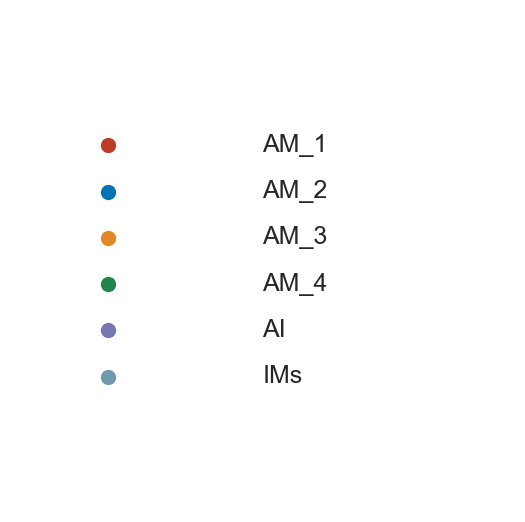

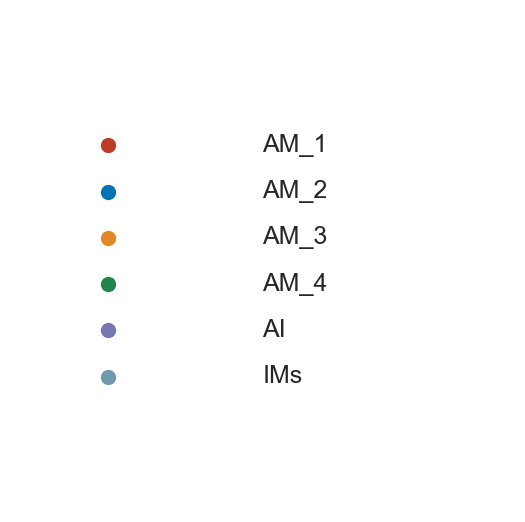

In [7]:
with Block("""ppara_cmap
    sp_all
    sp_mh
    sp_mma
    sp_mah
    cell_type_all
    cell_type
    m_infected_status
"""):
    # sp
    data = {k: v for k, v in zip('mouse,human,macaque'.split(','),
                                 '#0073C2,#EFC000,#CD534C'.split(','))}
    ppara_cmap['sp_all'] = data
    ppara_cmap['sp_mh'] = subset_dict(data, 'mouse,human'.split(','))
    ppara_cmap['sp_mma'] = subset_dict(data, 'mouse,macaque'.split(','))
    ppara_cmap['sp_mah'] = subset_dict(data, 'macaque,human'.split(','))
    del data

    # cell_type_all
    # ppara_cmap['Mtb_cell_type_all'] = {k:v for k,v in 
    #     zip('AM_1,AM_2,AM_3,AM_4,AI,IMs'.split(','),
    #         pl.cmap.ggsci.get_colors('D3-category20c')[10:])}
    ppara_cmap['Mtb_cell_type_all'] = pl.cmap.ggsci.get_cmap('NEJM','AM_1,AM_2,AM_3,AM_4,AI,IMs'.split(','))
    # cell_type
    ppara_cmap['Mtb_cell_type'] = subset_dict(
        ppara_cmap['Mtb_cell_type_all'],
        'AM_1,AM_2,AM_3,AM_4,IMs'.split(','))
    ppara_cmap['Mtb_m_infected_status'] = pl.cmap.ggsci.get_cmap('NPG-nrc',
                                                                 'Uninfected,Bystander,Infected'.split(','))
show_dict_key(ppara_cmap, 'ppara_cmap')
pl.cmap.show(ppara_cmap['Mtb_cell_type_all'])

# COVID

In [8]:
with Block("ppara_data['res_COVID']", context=dict(item='COVID')) as context:
    df = get_test_result_df(p_res)
    df = df.query("tissue == '{}'".format(context.item))
    df['epochs'] = df['resdir_tag']\
        .str.extract("epochs=(\\d+)", expand=False)\
        .fillna('')
    df = df.query("epochs == '500' ")
    df['time_tag'] = df['name'].str.extract(
        ';(\\d{6}-\\d{4})$', expand=False).fillna('')
    df = df[df['time_tag'].str.len() == 0]
    df = df.drop(columns=['time_tag'])

    df['__index'] = ut.df.apply_merge_field(df, "{model};{name_ref}")
    df = ut.df.reindex_with_unique_col(df, '__index', drop=True)

    df['F1-score'] = df.apply(get_res_stat,
                              key='F1-score',
                              q="dataset_type == 'que'",
                              axis=1)
    df['Accuracy'] = df.apply(
        get_res_stat, key='Accuracy',
        q="dataset_type == 'que'",
        axis=1)

    ppara_data['res_COVID'] = df
    del df
    data = pd.read_csv(p_cache.joinpath(
        'parameter_{}.csv'.format(context.item)
    ))
    data = data[data['name_ref'].str.endswith('-c')]
    data = ut.df.reindex_with_unique_col(data, 'name_ref')
    data['path_ref'] = data['path_ref'].apply(
        lambda x: p_cache.joinpath(x))
    data['path_que'] = data['path_que'].apply(
        lambda x: p_cache.joinpath(x))
    ppara_data['para_COVID'] = data
    del data

with Block("ppara_adata", context=dict(df=ppara_data['res_COVID'])
           ) as context:
    ppara_adata['COVID-mah'] = get_adata_umap(
        context.df.loc['csMAHN;COVID-ma-c'])
    ppara_adata['COVID-mah-mar'] = get_adata_umap(
        context.df.loc['csMAHN;COVID-ma-mar-c'], False)
    # 去除 Mac_dead 658
    data = ppara_adata['COVID-mah-mar'].obs
    data = data.query(
        " ((dataset_type == 'ref') & (true_label != 'Mac_dead')) | \
((dataset_type == 'que') & (pre_label != 'Mac_dead'))")
    ppara_adata['COVID-mah-mar'] = ppara_adata['COVID-mah-mar'][data.index, :].copy()

with Block("""
ppara_adata
    COVID-mar-ref
    COVID-mar-que
"""):
    # ref
    ppara_adata['COVID-mar-ref'] = load_normalized_adata(
        ppara_data['para_COVID'].at['COVID-ma-mar-c', 'path_ref'],
        ppara_adata['COVID-mah-mar'].obs
    )
    ppara_adata['COVID-mar-ref'] = ppara_adata['COVID-mar-ref'][
        ppara_adata['COVID-mah-mar'].obs.query("dataset_type == 'ref'").index, :].copy()
    ppara_adata['COVID-mar-ref'] = ut.sc.load_obsm_UMAP(
        ppara_adata['COVID-mar-ref'])
    # que
    ppara_adata['COVID-mar-que'] = load_normalized_adata(
        ppara_data['para_COVID'].at['COVID-ma-mar-c', 'path_que'],
        ppara_adata['COVID-mah-mar'].obs
    )
    ppara_adata['COVID-mar-que'] = ppara_adata['COVID-mar-que'][
        ppara_adata['COVID-mah-mar'].obs.query("dataset_type == 'que'").index, :].copy()
    ppara_adata['COVID-mar-que'] = ut.sc.load_obsm_UMAP(
        ppara_adata['COVID-mar-que'])


with Block("""
ppara_data
    COVID_obs_hu_mar_pre_labl_count
    COVID_obs_hu_mar_pre_labl_ratio
    COVID_obs_hu_mar_pre_labl_ratio_clinical
"""):
    data = ppara_adata['COVID-mah-mar'].obs.query("dataset_type == 'que'") .loc[
        :,
        'dataset,dataset_type,sp,cell_type,pre_label,true_label,preobs_X_batch'.split(',')] .rename(
        columns={
            'preobs_X_batch': '_batch'}) .reset_index(
                names='cell_name')
    data = ut.df.group_agg(
        data,
        '_batch,pre_label'.split(','),
        rename_dict={
            'pre_label_count': 'count'}) .pivot(
        index='_batch',
        columns='pre_label',
        values='count').fillna(0)
    ppara_data['COVID_obs_hu_mar_pre_labl_count'] = data
    ppara_data['COVID_obs_hu_mar_pre_labl_ratio'] = (
        data.transpose() /
        data.sum(
            axis=1)) .pipe(
        ut.pl.bar_cumsum_df_plot) .pipe(
                ut.pl.bar_transpose_df_cumsum) .filter(
                    regex="(?<!bottom_)Mac.+")

    # info_clinical.csv
    ppara_data['COVID_obs_hu_mar_pre_labl_ratio_clinical'] = pd.read_csv(
        Path('~/link/disease/dataset/COVID_hu_GSE157344/info_clinical.csv').expanduser())\
        .query("tissue == 'BAL'")\
        .pipe(ut.df.reindex_with_unique_col, '_batch', True)\
        .loc[:, 'subject_id,sofa_score,age,sex,clinical_outcome'.split(',')]\
        .join((data.transpose()/data.sum(axis=1)).transpose())

    del data


with Block("""
ppara_data
    COVID_marker_mar
"""):
    ppara_data['COVID_marker_mar'] = {
        'Mac_2': {
            'ref': 'CD14'.split(','),
            'que': ''.split(','),
        },
        'Mac_TREM2_IFN': {
            'ref': 'TREM2,IFI27'.split(','),
            'que': 'TREM2,IFI27'.split(','),
        }
    }

show_dict_key(ppara_adata, 'ppara_adata')
show_dict_key(ppara_data, 'ppara_data')


[extract]
^(?P<tissue>.+)_(?P<sp_ref>.+)-corss-(?P<sp_que>.+);(?P<model>came|csMAHN|Seurat|SAMap);(?P<name_ref>[\w-]+)-map-(?P<name_que>[[\w-]+);?(?P<resdir_tag>.+)?$
> ppara_adata['']----------------------------------------------------------
  COVID-mah
  COVID-mah-mar
  COVID-mar-que
  COVID-mar-ref
  Mtb_mh
  Mtb_que
  Mtb_ref
> ppara_data['']-----------------------------------------------------------
  COVID_marker_mar
  COVID_obs_hu_mar_pre_labl_count
  COVID_obs_hu_mar_pre_labl_ratio
  COVID_obs_hu_mar_pre_labl_ratio_clinical
  Mtb_DEG_h
  Mtb_DEG_h_sub_cell_type
  Mtb_DEG_m
  Mtb_marker_AM_IM
  Mtb_marker_h_IM
  Mtb_marker_mh
  Mtb_mh_confusion_matrix
  Mtb_mh_confusion_matrix_ratio
  Mtb_mh_sp
  homo_mah
  homo_mh
  key_scpl_show_genes
  marker_dotplot
  para_COVID
  para_Mtb
  res_COVID
  res_Mtb


In [9]:
with Block('ppara_cmap'):
    ppara_cmap['COVID-ma_true_label'] = pl.cmap.ggsci.get_cmap('D3-category20c',
                                                               'B cell,DC,Macrophage,Mast,Prolif,T & NK,non_imm,pDC'.split(','))
    ppara_cmap['COVID-ma-mar_true_label'] = pl.cmap.ggsci.get_cmap('D3-category20b',
                                                                   'Mac,Mac_2,Mac_3,Mac_FOS,Mac_IFN_2,Mac_IFN_1,Mac_S100A8,Mac_TREM2,Mac_TREM2_IFN'.split(','))
show_dict_key(ppara_cmap, 'ppara_cmap')

> ppara_cmap['']-----------------------------------------------------------
  COVID-ma-mar_true_label
  COVID-ma_true_label
  Mtb_cell_type
  Mtb_cell_type_all
  Mtb_m_infected_status
  sp_all
  sp_mah
  sp_mh
  sp_mma


# plot

[out][plot] Mtb_COVID_csMAHN.png 
	in /public/workspace/licanchengup/link/res_publish/plot/pdf
[out][plot] Mtb_COVID_csMAHN.svg 
	in /public/workspace/licanchengup/link/res_publish/plot/pdf
***************************************************************************
(A) The UMAP plot of embeddings outputted by macrophage for human and mouse
bronchoalveolar lavage, applied with csMAHN. (B) Dot plot showing posterior
probability of the human macrophage integrating mouse and human bronchoalveolar
lavage macrophage using csMAHN, The size of the dots corresponds to the
proportion of each original label that is assigned to each csMAHN label.
gene expression marker of macrophage subclusters. (C) AMs and IMs, (D) AM_4,
(top panel) mouse and (bottom panel) human. (E) Proportional distribution
of IMs. (F) Gene expression marker of AM_1, AM_2, AM_4. (G) The UMAP plot
of embeddings outputted by macrophage for macaque and human COVID-19 infected
bronchoalveolar lavage, applied with csMAHN. (H) Gene 

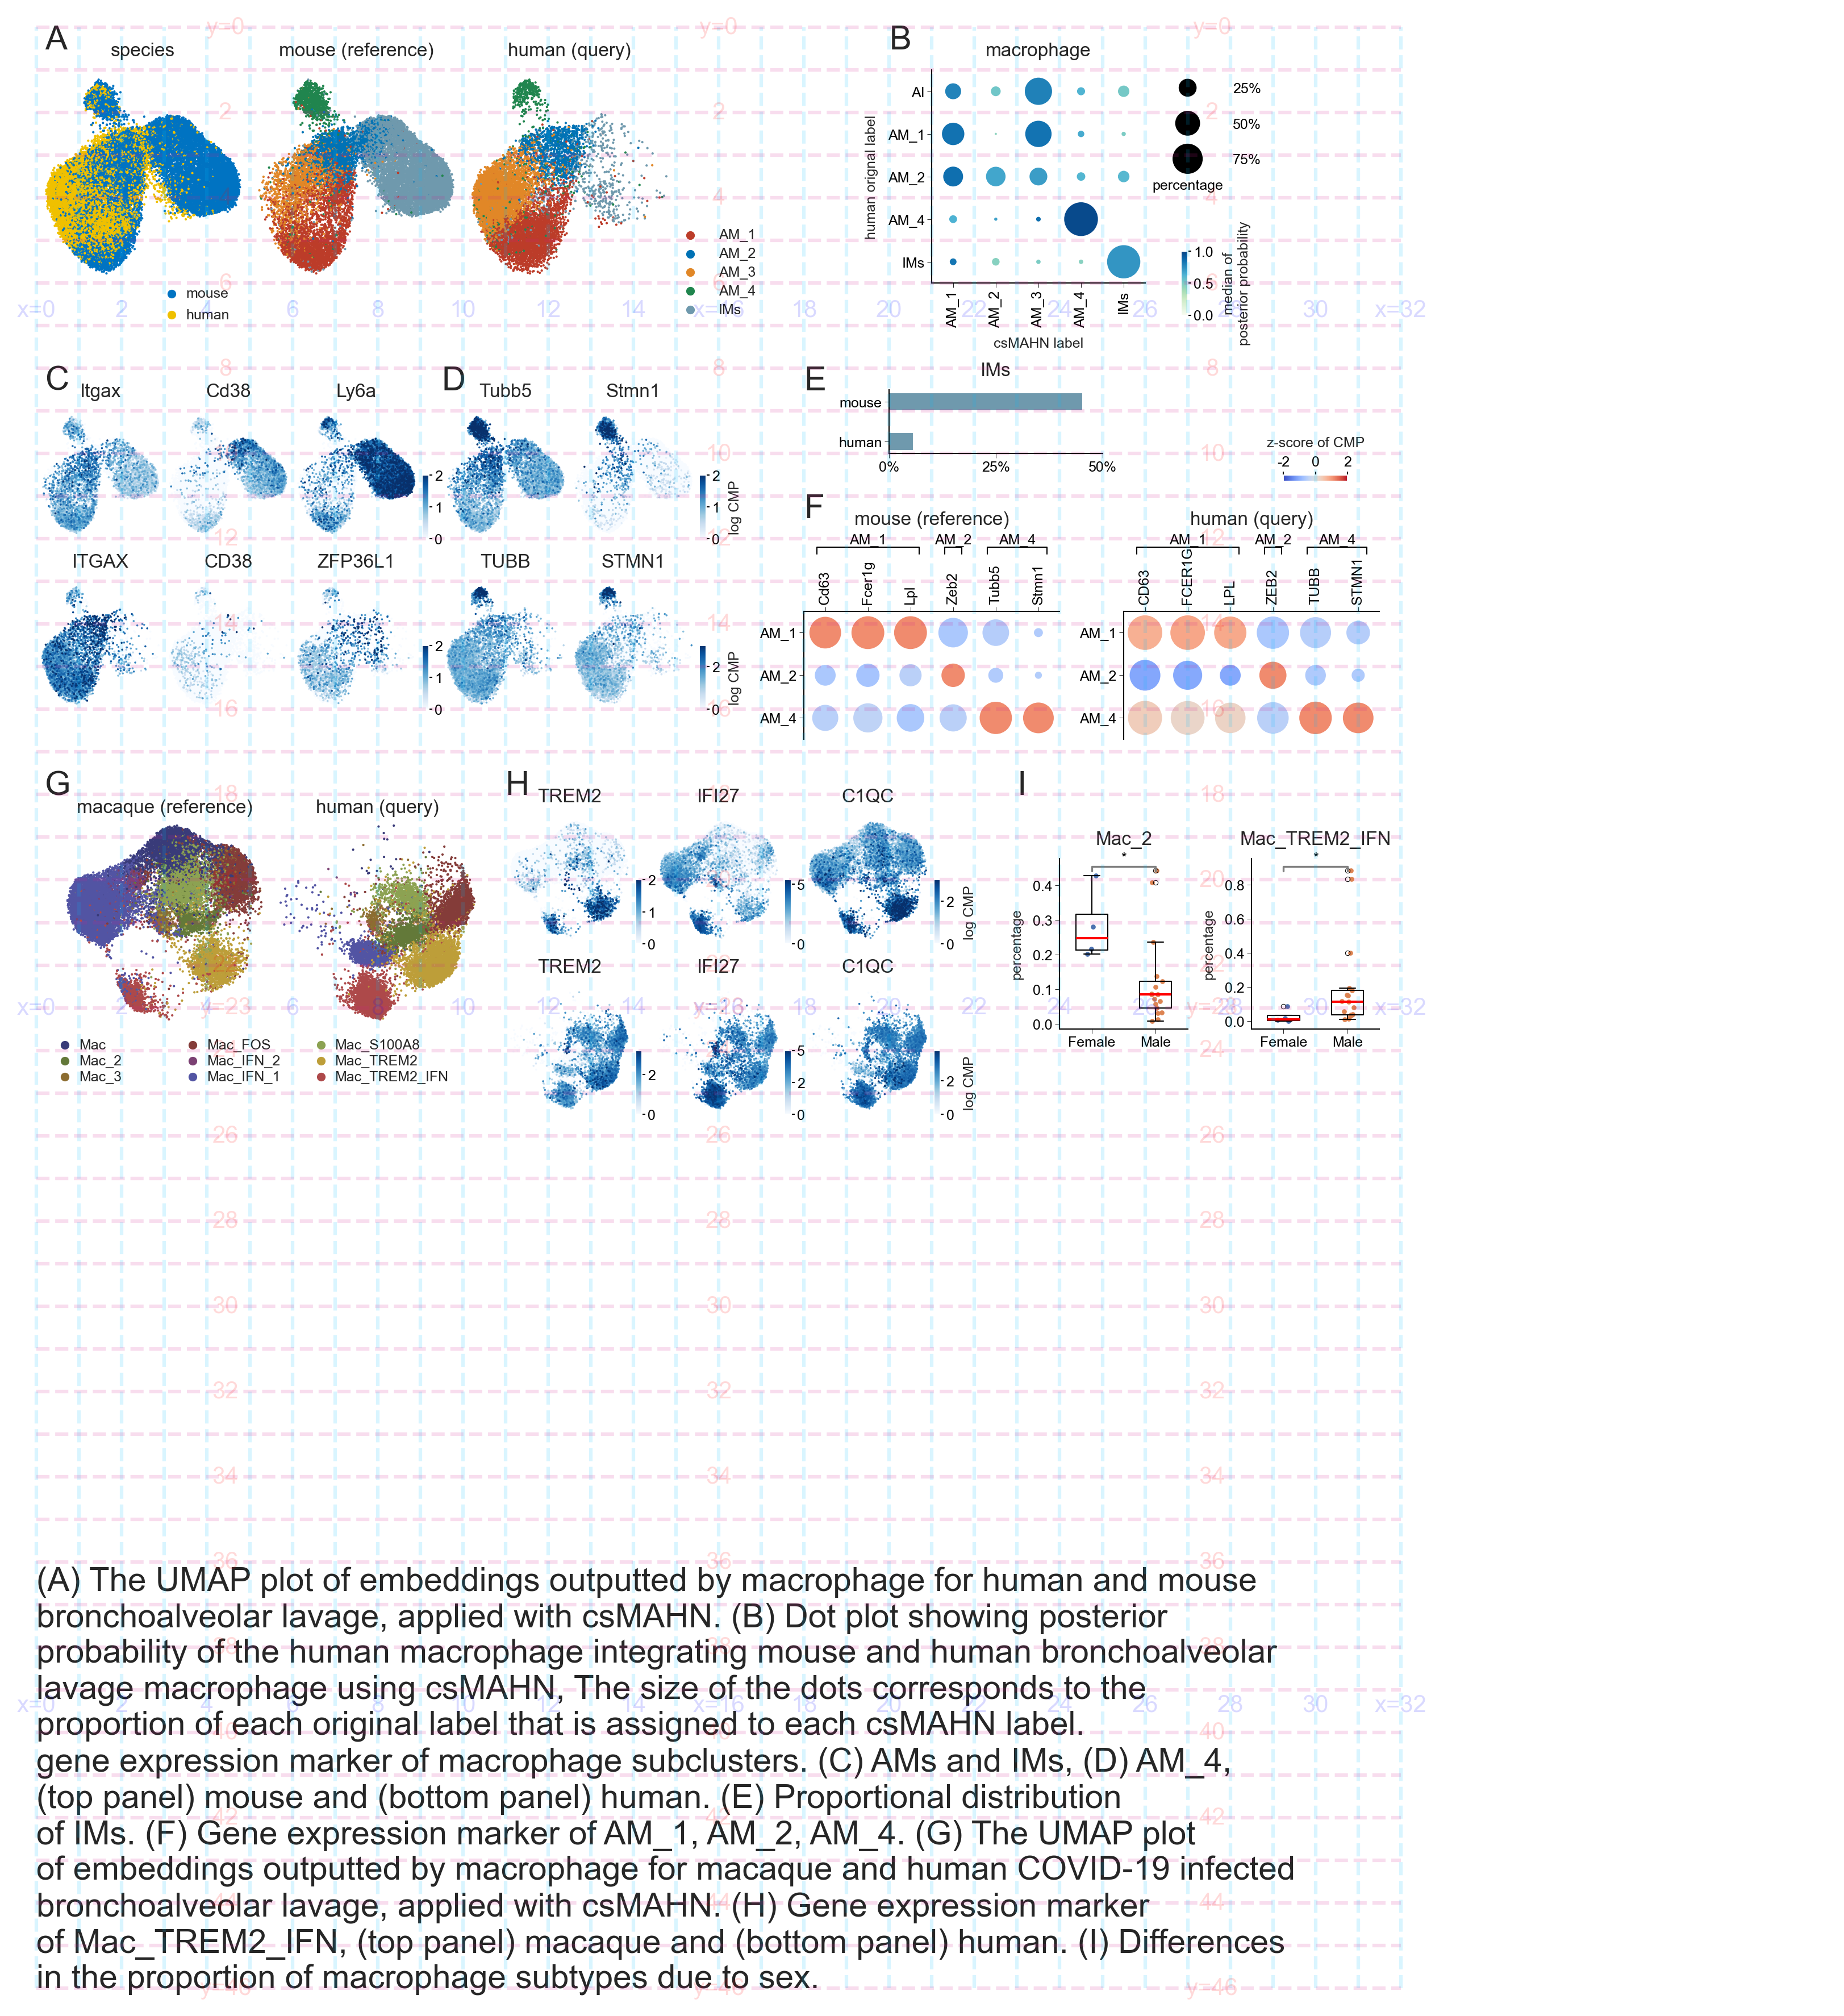

In [10]:
plt.close("all")

a4p = pl.figure.A4Page()
# Mtb --------------------------------------------------
y = 1
with Block("Mtb UMAP", context=dict(x=0, y=y,size = 1)) as context:
    ax = a4p.add_ax(context.x, context.y, 5, 5)
    ut.sc.pl.umap(ppara_adata['Mtb_mh'], 'sp', ax,
                  cmap=ppara_cmap['sp_mh'],
                  size=context.size)
    ax.set_rasterized(True)
    ax.set_title('species')

    ax = a4p.add_ax(context.x+5, context.y, 5, 5)
    ut.sc.pl.umap(ppara_adata['Mtb_ref'],'model_label_1',ax,
        cmap=ppara_cmap['Mtb_cell_type'],size=context.size)
    ax.set_rasterized(True)
    ax.set_title('mouse (reference)')

    ax = a4p.add_ax(context.x+10, context.y, 5, 5)
    ut.sc.pl.umap(ppara_adata['Mtb_que'],'model_label_1',ax,
        cmap=ppara_cmap['Mtb_cell_type'],size=context.size)
    ax.set_rasterized(True)
    ax.set_title('human (query)')

    with Block("UMAP legend"):

        ax = a4p.add_ax(context.x+3, context.y+5, 1, 1)
        pl.cmap.show(ppara_cmap['sp_mh'], ax=ax)
        ax = a4p.add_ax(context.x+15, context.y+3, 2, 3.5)
        pl.cmap.show(subset_dict(ppara_cmap['Mtb_cell_type_all'],
                'AM_1,AM_2,AM_3,AM_4,IMs'.split(',')),ax=ax)
    del ax

with Block('posterior probability', context=dict(x=21, y=y, cmap='GnBu')) as context:
    data = ppara_adata['Mtb_mh'].obs.query("dataset_type == 'que'")\
        .loc[:, 'preobs_sub_cell_type,pre_label,max_prob'.split(',')]\
        .rename(columns={'preobs_sub_cell_type': 'original label', 'pre_label': 'csMAHN label'})\
        .copy()
    data['original label'] = data['original label'].map(lambda k: {'IM_1': 'IMs'}.setdefault(k, k))
    data = data.rename(columns={'original label': 'true_label', 'csMAHN label': 'pre_label'})
    ppara = dict(
        data=data,
        kw_bubble=dict(vmax=1, vmin=0, cmap=context.cmap),
        order_col='AM_1,AM_2,AM_3,AM_4,IMs'.split(','),
        order_row='AI,AM_1,AM_2,AM_4,IMs'.split(',')
    )
    kw_cbar = dict(format='{x:.1f}', aspect=10, label='median of\nposterior probability')
    # plot
    ax = a4p.add_ax(
        context.x, context.y, len(
            ppara['order_col']), len(
            ppara['order_row']), rc=pl.rc_frame)
    ax.set_title('macrophage')
    cbar = dotplot_max_prob_median(ax=ax, **ppara)
    ax.set_ylabel('human orignal label')
    ax.set_xlabel('csMAHN label')

    ax = a4p.add_ax(context.x+5, context.y, 2, 2.5, rc=update_dict(pl.rc_blank,
                                                                   {'ytick.labelright': True, 'xtick.labelbottom': True}))
    dotplot_marker_legend(ax, draw_cbar=False)
    ax = a4p.add_ax(context.x+5, context.y+4, 1, 2, rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del data, ppara, kw_cbar, ax, cbar

y += 8
with Block("UMAP gene AM IM", context=dict(x=0, y=y, key='AM-IM',cmap='Blues')) as context:
    ppara = dict(draw_cbar=False, size=.5, cmap=context.cmap, layer='log1p')
    kw_cbar = dict(format='{x:.0f}', aspect=10)
    with Block("gene mouse"):
        ppara.update(adata=ppara_adata['Mtb_ref'], vmax=2, vmin=0)
        a4p.area_update(context.x, context.y, 1, 3, 3, 3)
        for ax, gene in zip(a4p.area_yield_ax(with_xy=False, rc=pl.rc_blank),
                            ppara_data['Mtb_marker_mh'][context.key]['ref']):
            cbar = ut.sc.pl.umap_gene(key=gene, ax=ax, **ppara)
            ax.set_title(gene)
            ax.set_rasterized(True)

    ax = a4p.add_ax(context.x+8.2, context.y+1.5, 1, 1.5, rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')

    with Block("gene human"):
        ppara.update(adata=ppara_adata['Mtb_que'], vmax=2, vmin=0)
        a4p.area_update(context.x, context.y+4, 1, 3, 3, 3, gap_width=0)
        for ax, gene in zip(a4p.area_yield_ax(
                rc=pl.rc_blank), ppara_data['Mtb_marker_mh'][context.key]['que']):
            cbar = ut.sc.pl.umap_gene(key=gene, ax=ax, **ppara)
            ax.set_title(gene)
            ax.set_rasterized(True)
    ax = a4p.add_ax(context.x+8.2, context.y+5.5, 1, 1.5, rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del ppara, kw_cbar, ax, gene, cbar

with Block("UMAP gene AM_4", context=dict(x=9.5, y=y, key='AM_4',cmap='Blues')) as context:
    kw_cbar = dict(format='{x:.0f}', aspect=10, label='log CMP')
    ppara = dict(draw_cbar=False, size=.5, cmap=context.cmap, layer='log1p')
    with Block("gene mouse"):
        ppara.update(adata=ppara_adata['Mtb_ref'], vmax=2, vmin=0)
        a4p.area_update(context.x, context.y, 1, 3, 3, 3, gap_width=0)
        for ax, gene in zip(
            a4p.area_yield_ax(
                rc=pl.rc_blank), ppara_data['Mtb_marker_mh'][context.key]['ref']):
            cbar = ut.sc.pl.umap_gene(key=gene, ax=ax, **ppara)
            ax.set_title(gene)
            ax.set_rasterized(True)
        ax = a4p.add_ax(context.x+5.2, context.y+1.5, 1, 1.5, rc=pl.rc_blank)
        cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
        cbar.ax.tick_params('both', width=.5, length=1.5, color='black')

    with Block("gene human"):
        ppara.update(adata=ppara_adata['Mtb_que'], vmax=3, vmin=0)
        a4p.area_update(context.x, context.y+4, 1, 3, 3, 3, gap_width=0)
        for ax, gene in zip(a4p.area_yield_ax(
                rc=pl.rc_blank), ppara_data['Mtb_marker_mh'][context.key]['que']):
            cbar = ut.sc.pl.umap_gene(key=gene, ax=ax, **ppara)
            ax.set_title(gene)
            ax.set_rasterized(True)
        ax = a4p.add_ax(context.x+5.2, context.y+5.5, 1, 1.5, rc=pl.rc_blank)
        cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
        cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del ppara, kw_cbar, ax, gene, cbar

with Block("bar IMs", context=dict(x=20, y=y-.5)) as context:
    ax = a4p.add_ax(context.x, context.y, 5, 1.5, rc=pl.rc_frame)
    df_plot = ppara_data['Mtb_mh_sp']
    cmap = ppara_cmap['Mtb_cell_type']
    # ut.df.show(df_plot)

    para = dict(gap_between_group=1, width_one_bar=1,
                width_ratio=.9, to_horizontal=True)
    pl.bar(ax, df_plot, key_height='IMs', cmap=cmap, **para)
    ax.set_xticks(np.arange(0, .6, .25), [
                  '{:.0f}%'.format(i*100) for i in np.arange(0, .6, .25)])
    ax.set_yticks([0, 2], df_plot.index)
    ax.set_title("IMs")
    del df_plot, cmap, para, ax

with Block('marker Mtb', context=dict(x=18, y=y+3)) as context:
    marker_dict = ppara_data['marker_dotplot']['Mtb']
    adata_ref = ppara_adata['Mtb_ref']
    adata_que = ppara_adata['Mtb_que']
    kw_cbar = dict(format='{x:.0f}', aspect=10, label='z-score of CMP',location='top',
                   orientation='horizontal')
    ppara = dict(
        key_group='model_label',
        transpose=True,
        kw_bubble=dict(vmax=2.5, vmin=-2.5, cmap='coolwarm'))

    with Block('ref'):
        ppara.update(adata=adata_ref,
                     genes=list(np.concatenate(list(marker_dict['ref'].values()))),
                     order='AM_1,AM_2,AM_4'.split(','))
        with Block('bar'):
            ax = a4p.add_ax(context.x, context.y, len(ppara['genes']), 1, rc=pl.rc_blank)
            ax.set_xlim(0, len(ppara['genes'])), ax.set_ylim(0, 1)
            pl.tl_stats_bar(ax, [0+.3, 3-.3], text='AM_1', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [3+.3, 4-.3], text='AM_2', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [4+.3, 6-.3], text='AM_4', bottom=.65, top=.8)
            ax.set_title('mouse (reference)')
        ax = a4p.add_ax(context.x,
                        context.y+1.7,
                        len(ppara['genes']),
                        len(ppara['order']),
                        rc=pl.rc_frame_lt)
        cbar = dotplot_marker(ax=ax, **ppara)
    context.x += 7.5
    with Block('que'):
        ppara.update(adata=adata_que,
                     genes=list(np.concatenate(list(marker_dict['que'].values()))),
                     order='AM_1,AM_2,AM_4'.split(','))
        with Block('bar'):
            ax = a4p.add_ax(context.x, context.y, len(ppara['genes']), 1, rc=pl.rc_blank)
            ax.set_xlim(0, len(ppara['genes'])), ax.set_ylim(0, 1)
            pl.tl_stats_bar(ax, [0+.3, 3-.3], text='AM_1', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [3+.3, 4-.3], text='AM_2', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [4+.3, 6-.3], text='AM_4', bottom=.65, top=.8)
            ax.set_title('human (query)')
        ax = a4p.add_ax(context.x,
                        context.y+1.7,
                        len(ppara['genes']),
                        len(ppara['order']),
                        rc=pl.rc_frame_lt)
        cbar = dotplot_marker(ax=ax, **ppara)

    ax = a4p.add_ax(context.x+3.5, context.y-1.5, 2, 1, rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del marker_dict, adata_ref, adata_que, kw_cbar, ppara

# COVID --------------------------------------------------
y += 9.5
with Block('COVID UMAP', context=dict(x=0.5, y=y,size=1)) as context:
    cmap = ppara_cmap['COVID-ma-mar_true_label']
    ax = a4p.add_ax(context.x, context.y, 5, 5)
    ut.sc.pl.umap(ppara_adata['COVID-mar-ref'],'true_label', size=context.size, ax=ax,cmap=cmap)
    ax.set_rasterized(True)
    ax.set_title('macaque (reference)', y=0.95)

    ax = a4p.add_ax(context.x+5, context.y, 5, 5)
    ut.sc.pl.umap(ppara_adata['COVID-mar-que'], 'pre_label',size=context.size, ax=ax,cmap=cmap)
    ax.set_rasterized(True)
    ax.set_title('human (query)', y=0.95)
    # legend
    a4p.area_update(context.x,context.y+5,1,3,1,1.5,gap_width=2)
    for ax,keys in zip(a4p.area_yield_ax(),np.array_split(list(cmap.keys()),3)):
        pl.cmap.show(subset_dict(cmap,keys),ax=ax)
    del ax,cmap,keys

with Block("UMAP gene COVID Mac_TREM2_IFN", context=dict(x=11, y=y,
        key='Mac_TREM2_IFN',cmap='Blues')) as context:
    kw_cbar = dict(format='{x:.0f}', aspect=10)
    kw_umap_gene = dict(layer='log1p', cmap=context.cmap)
    adata_ref = ppara_adata['COVID-mar-ref']
    adata_que = ppara_adata['COVID-mar-que']
    gene = 'TREM2'
    
    ppara_func['ut_sc_umap_gene'](a4p, context.x, context.y,adata_ref,
                                  kw_umap_gene=update_dict(kw_umap_gene,vmax=2, vmin=0),
                                  kw_cbar=kw_cbar,gene=gene,draw_cbar=True)
    ppara_func['ut_sc_umap_gene'](a4p, context.x, context.y+4, adata_que,
                                  kw_umap_gene=update_dict(kw_umap_gene,vmax=3.2, vmin=0),
                                  gene = gene,draw_cbar=True,kw_cbar=kw_cbar)

    context.x += 3.5
    gene = 'IFI27'
    ppara_func['ut_sc_umap_gene'](a4p, context.x, context.y, adata_ref, gene,
                                  kw_umap_gene=update_dict(kw_umap_gene,vmax=None, vmin=0),
                                  draw_cbar=True, kw_cbar=kw_cbar)
    ppara_func['ut_sc_umap_gene'](a4p, context.x, context.y+4, adata_que, gene,
                                  kw_umap_gene=update_dict(kw_umap_gene,vmax=5, vmin=0),
                                  draw_cbar=True,kw_cbar=kw_cbar)

    context.x += 3.5
    gene = 'C1QC'
    kw_cbar.update(label='log CMP')
    ppara_func['ut_sc_umap_gene'](a4p, context.x, context.y, adata_ref, gene,
                                  kw_umap_gene=update_dict(kw_umap_gene, vmax=3, vmin=0),
                                  draw_cbar=True,  kw_cbar=kw_cbar)
    ppara_func['ut_sc_umap_gene'](a4p, context.x, context.y+4, adata_que, gene,
                                  kw_umap_gene=update_dict(kw_umap_gene, vmax=4.8, vmin=0),
                                  draw_cbar=True,kw_cbar=kw_cbar)
    del gene, kw_cbar,kw_umap_gene,adata_ref,adata_que
# y += 8
with Block('box plot', context=dict(x=24, y=y+1,
                                    key='sex', values=np.array('Female,Male'.split(',')))) as context:

    df_plot = ppara_data['COVID_obs_hu_mar_pre_labl_ratio_clinical']
    a4p.area_update(context.x, context.y, 1, 2, 3, 4, gap_width=1.5)
    for ax, key in zip(a4p.area_yield_ax(rc=pl.rc_frame),
                       'Mac_2,Mac_TREM2_IFN'.split(',')):
        for i, v in zip(np.arange(context.values.size)+1, context.values):
            temp = df_plot.query("{} == '{}'".format(
                context.key, v)).loc[:, key]
            pl.boxplot(temp, positions=[i], ax=ax, widths=.5)
            ax.scatter(np.repeat(i, temp.size)+pl.tl_jitter(temp.size, .2),
                       temp, s=2.5, label=v)
        ax.set_xticks(np.arange(context.values.size)+1, context.values)
        ax.set_title(key)
        ax.set_ylabel('percentage')
        with Block('mannwhitneyu', context=dict(res_stats=ut.sc.
                                                scipy.stats.mannwhitneyu(
                df_plot.query("{} == '{}'".format(context.key, context.values[0])).loc[:, key],
                df_plot.query("{} == '{}'".format(context.key, context.values[1])).loc[:, key]
                                                ))) as context2:
            pl.tl_stats_bar(ax, [1, 2], .95, .98, 
                kvarg_line=dict(color='grey', lw=.8), text=pl.tl_get_significance_marker(
                    context2.res_stats.pvalue), fontdict=pl.tl_fontdict('cb'))
    del df_plot, temp, ax, key

with Block('text'):
    for text, (x, y) in zip(
        [chr(65+i) for i in range(26)],
            np.array([
                [.2, .5], [20, .5], [.2, 8.5], [9.5, 8.5],  # ABCD
                [18, 8.5], [18, 11.5], [.2, 18],[11, 18],# EFGH
                [23, 18],# I
            ])):
        a4p.add_text_with_ax(
            a4p.add_ax(x, y), text)

pl.tl_savefig(a4p.fig, '{}_{}.png'.format(item, model), p_pdf)
pl.tl_savefig(a4p.fig, '{}_{}.svg'.format(item, model), p_pdf)

with Block('note'):
    text = "(A) The UMAP plot of embeddings outputted by macrophage for human and mouse bronchoalveolar lavage, applied with csMAHN. \
(B) Dot plot showing posterior probability of the human macrophage integrating mouse and human bronchoalveolar lavage macrophage using csMAHN, \
The size of the dots corresponds to the proportion of each original label that is assigned to each csMAHN label. \
gene expression marker of macrophage subclusters. (C) AMs and IMs, (D) AM_4, (top panel) mouse and (bottom panel) human. \
(E) Proportional distribution of IMs. \
(F) Gene expression marker of AM_1, AM_2, AM_4. \
(G) The UMAP plot of embeddings outputted by macrophage for macaque and human COVID-19 infected bronchoalveolar lavage, applied with csMAHN. \
(H) Gene expression marker of Mac_TREM2_IFN, (top panel) macaque and (bottom panel) human. \
(I) Differences in the proportion of macrophage subtypes due to sex. \
"
    text = pl.tl_str_next_line(text, 75, ' ')
    a4p.add_text_with_ax(a4p.add_ax(0, 45, 42),
                         text, 0, 0)
    print("{1}\n{0}\n{1}".format(text, '*'*75))
    del text

a4p.save_as_pdf(p_pdf.joinpath('{}_{}.pdf'.format(item, model)))
a4p.add_grid()
a4p.fig

[out][plot] Mtb_COVID_csMAHN_supp_1.png 
	in /public/workspace/licanchengup/link/res_publish/plot/pdf
[out][plot] Mtb_COVID_csMAHN_supp_1.svg 
	in /public/workspace/licanchengup/link/res_publish/plot/pdf
***************************************************************************
 (A) UMAP plot of mouse cell, colored by infected status. gene expression marker
of each subclusters. (B) AM_1, (C) AM_2, (D) AI; (top panel) mouse and
(bottom panel) human. (E) Gene expression marker of IM_1 and IM_2 in human
cells. (F) The UMAP plot of embeddings outputted by  BAL cell for macaque
and human COVID-19 infected bronchoalveolar lavage, applied with csMAHN. (G)
Dot plot showing posterior probability of the human BAL cell integrating
macaque and human BAL cell using csMAHN, The size of the dots corresponds to
the proportion of each original label that is assigned to each csMAHN label.

***************************************************************************


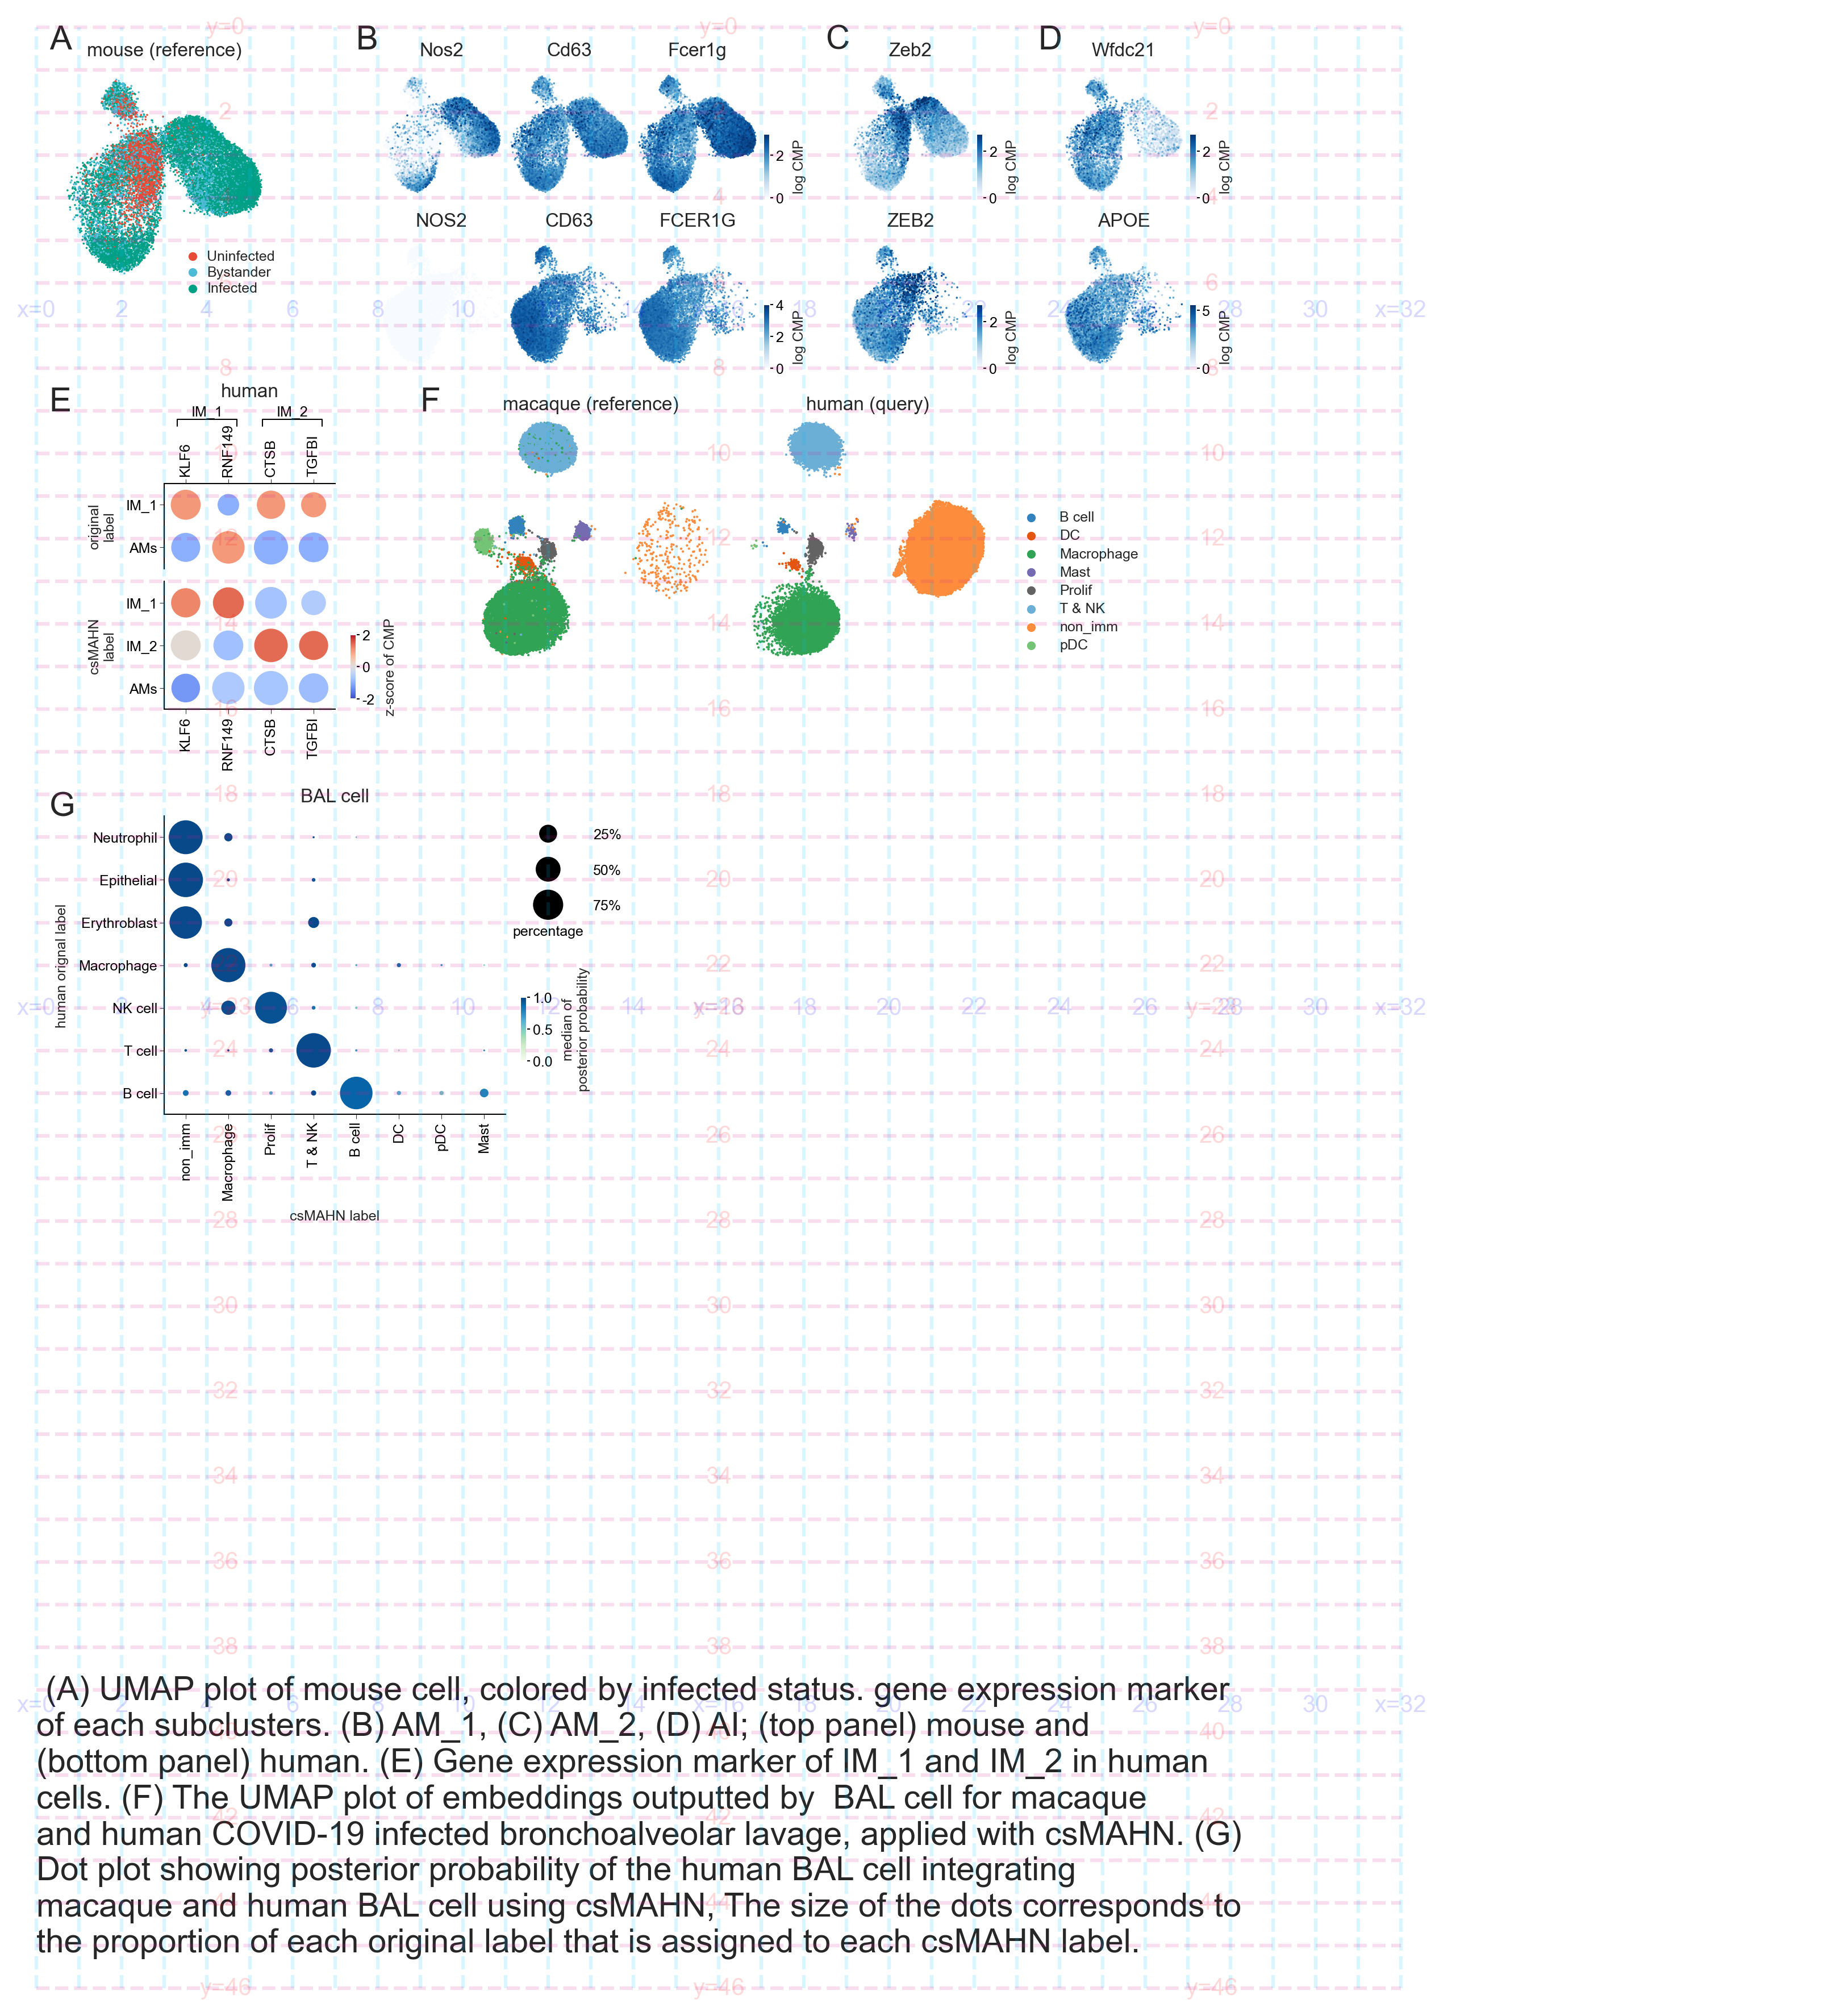

In [11]:
plt.close("all")
a4p = pl.figure.A4Page()

# COVID ------------------------------------------------------------
y = 1

with Block("Mtb UMAP Infected Status", context=dict(x=.5, y=y)) as context:
    ax = a4p.add_ax(context.x, context.y, 5, 5)
    ut.sc.pl.umap(ppara_adata['Mtb_ref'],'Treatment',ax,
        cmap=ppara_cmap['Mtb_m_infected_status'],
        size=.5,sort=False,ax_cmap=a4p.add_ax(context.x+3,context.y+4,1,1.5))
    ax.set_rasterized(True)
    ax.set_title('mouse (reference)')

with Block("UMAP gene AM_1", context=dict(x=8, y=y, key='AM_1',cmap='Blues')) as context:
    kw_cbar = dict(format='{x:.0f}', aspect=10, label='log CMP')
    ppara = dict(draw_cbar=False, size=.5, cmap=context.cmap, layer='log1p')
    with Block("gene mouse"):
        a4p.area_update(context.x, context.y, 1, 3, 3, 3, gap_width=0)
        for ax, gene in zip(a4p.area_yield_ax(rc=pl.rc_blank),
                            ppara_data['Mtb_marker_mh'][context.key]['ref']):
            cbar = ut.sc.pl.umap_gene(ppara_adata['Mtb_ref'], gene, ax=ax, vmax=3, vmin=0, **ppara)
            ax.set_title(gene)
            ax.set_rasterized(True)
    ax = a4p.add_ax(context.x+8.2, context.y+1.5, 1, 1.5, rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')

    with Block("gene human"):
        a4p.area_update(context.x, context.y+4, 1, 3, 3, 3, gap_width=0)
        for ax, gene in zip(a4p.area_yield_ax(rc=pl.rc_blank),
                            ppara_data['Mtb_marker_mh'][context.key]['que']):
            cbar = ut.sc.pl.umap_gene(ppara_adata['Mtb_que'], gene, ax=ax, vmax=4, vmin=0, **ppara)
            ax.set_title(gene)
            ax.set_rasterized(True)
    ax = a4p.add_ax(context.x+8.2, context.y+5.5, 1, 1.5, rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')

    del kw_cbar, ppara, ax, gene, cbar

with Block("UMAP gene AM_2", context=dict(x=19, y=y, key='AM_2',cmap='Blues')) as context:
    kw_cbar = dict(format='{x:.0f}', aspect=10,label='log CMP')
    ppara = dict(draw_cbar=False, size=.5, cmap=context.cmap, layer='log1p')
    with Block("gene mouse"):
        a4p.area_update(context.x, context.y, 1, 3, 3, 3, gap_width=0)
        for ax, gene in zip(a4p.area_yield_ax(rc=pl.rc_blank),
                            ppara_data['Mtb_marker_mh'][context.key]['ref']):
            cbar = ut.sc.pl.umap_gene(ppara_adata['Mtb_ref'], gene, ax, vmax=2.75, vmin=0, **ppara)
            ax.set_title(gene)
            ax.set_rasterized(True)
    ax = a4p.add_ax(context.x+2.2, context.y+1.5, 1, 1.5, rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    with Block("gene human"):
        a4p.area_update(context.x, context.y+4, 1, 3, 3, 3, gap_width=0)
        for ax, gene in zip(a4p.area_yield_ax(rc=pl.rc_blank),
                ppara_data['Mtb_marker_mh'][context.key]['que']):
            cbar = ut.sc.pl.umap_gene(ppara_adata['Mtb_que'], gene, ax, vmax=2.75, vmin=0, **ppara)
            ax.set_title(gene)
            ax.set_rasterized(True)
    ax = a4p.add_ax(context.x+2.2, context.y+5.5, 1, 1.5, rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del kw_cbar, ppara, ax, gene, cbar

with Block("UMAP gene AM_3", context=dict(x=24, y=y, key='AM_3',cmap='Blues')) as context:
    kw_cbar = dict(format='{x:.0f}', aspect=10, label='log CMP')
    ppara = dict(draw_cbar=False, size=.5, cmap=context.cmap, layer='log1p')
    with Block("gene mouse"):
        a4p.area_update(context.x, context.y, 1, 3, 3, 3, gap_width=0)
        for ax, gene in zip(
            a4p.area_yield_ax(
                rc=pl.rc_blank), ppara_data['Mtb_marker_mh'][context.key]['ref']):
            cbar = ut.sc.pl.umap_gene(ppara_adata['Mtb_ref'], gene, ax, vmax=2.75, vmin=0, **ppara)
            ax.set_title(gene)
            ax.set_rasterized(True)
        ax = a4p.add_ax(context.x+2.2, context.y+1.5, 1, 1.5, rc=pl.rc_blank)
        cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
        cbar.ax.tick_params('both', width=.5, length=1.5, color='black')

    with Block("gene human"):
        a4p.area_update(context.x, context.y+4, 1, 8, 3, 3, gap_width=0)
        for ax, gene in zip(a4p.area_yield_ax(rc=pl.rc_blank),
                            ppara_data['Mtb_marker_mh'][context.key]['que']):
            cbar = ut.sc.pl.umap_gene(ppara_adata['Mtb_que'], gene, ax, vmax=5.5, vmin=0, **ppara)
            ax.set_title(gene)
            ax.set_rasterized(True)

        ax = a4p.add_ax(context.x+2.2, context.y+5.5, 1, 1.5, rc=pl.rc_blank)
        cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
        cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del kw_cbar, ppara, ax, gene, cbar
y += 8

with Block('marker h IM_1', context=dict(x=3, y=y)) as context:
    with Block('adata_que'):
        adata_que = ppara_adata['Mtb_que']
        df_obs = adata_que.obs
        df_obs['IM_1_marker_model_label'] = df_obs['pre_label_1'].mask(
            df_obs['pre_label_1'].str.startswith('AM_'),'AMs')
        df_obs['IM_1_marker_orignal_label'] = df_obs['preobs_sub_cell_type'].mask(
            df_obs['preobs_sub_cell_type'].str.startswith('AM_'),'AMs')
        adata_que.obs = df_obs
        del df_obs
    marker_dict = {
        'IM_1':'KLF6,RNF149'.split(','),
        'IM_2':'CTSB,TGFBI'.split(',')
    }
    kw_cbar = dict(format='{x:.0f}', aspect=10, label='z-score of CMP')
    ppara = dict(transpose=True,zscore=True,
        kw_bubble=dict(vmax=2, vmin=-2, cmap='coolwarm'))
    with Block('que'):
        ppara.update(adata=adata_que,
                     key_group='IM_1_marker_orignal_label',
                     genes=list(np.concatenate(list(marker_dict.values()))),
                     order='IM_1,AMs'.split(','))
        with Block('bar'):
            ax = a4p.add_ax(context.x, context.y, len(ppara['genes']), 1, rc=pl.rc_blank)
            ax.set_xlim(0, len(ppara['genes'])), ax.set_ylim(0, 1)
            pl.tl_stats_bar(ax, [0+.3, 2-.3], text='IM_1', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [2+.3, 4-.3], text='IM_2', bottom=.65, top=.8)
            ax.set_title('human')
        ax = a4p.add_ax(context.x,context.y+1.7,
                        len(ppara['genes']),len(ppara['order']),
                        rc=pl.rc_frame_lt)
        ax.set_ylabel('original\nlabel')
        cbar = dotplot_marker(ax=ax, **ppara)

    ppara.update(key_group='IM_1_marker_model_label',
                 order='IM_1,IM_2,AMs'.split(','))
    ax = a4p.add_ax(context.x,context.y+4,
        len(ppara['genes']),len(ppara['order']),rc=pl.rc_frame)
    ax.set_ylabel('csMAHN\nlabel')
    cbar = dotplot_marker(ax=ax, **ppara)
    
    ax = a4p.add_ax(context.x+3.5, context.y+5, 1, 2, rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del marker_dict, adata_que, kw_cbar, ppara,cbar,ax

# COVID ------------------------------------------------------------

with Block('COVID UMAP all', context=dict(x=10, y=y)) as context:
    ax = a4p.add_ax(context.x, context.y, 6, 6)
    ut.sc.pl.umap(ut.sc.subset_adata(
        ppara_adata['COVID-mah'],
        'dataset_type', 'ref'),
        'true_label', size=1, ax=ax,
        cmap=ppara_cmap['COVID-ma_true_label'])
    ax.set_rasterized(True)
    ax.set_title('macaque (reference)', y=0.95)

    ax = a4p.add_ax(context.x+6.5, context.y, 6, 6)
    ut.sc.pl.umap(ut.sc.subset_adata(
        ppara_adata['COVID-mah'], 'dataset_type', 'que'),
        'pre_label', size=1, ax=ax,
        cmap=ppara_cmap['COVID-ma_true_label'])
    ax.set_rasterized(True)
    ax.set_title('human (query)', y=0.95)

    # legend
    ax = a4p.add_ax(context.x+13, context.y+1, 2, 6)
    pl.cmap.show(ppara_cmap['COVID-ma_true_label'], ax=ax)
y += 9.5
with Block('posterior probability COVID all', context=dict(x=3, y=y, cmap='GnBu')) as context:
    data = ppara_adata['COVID-mah'].obs
    ppara = dict(
        data=data,
        kw_bubble=dict(vmax=1, vmin=0, cmap=context.cmap),
        order_col='non_imm,Macrophage,Prolif,T & NK,B cell,DC,pDC,Mast'.split(','),
        order_row='Neutrophil,Epithelial,Erythroblast,Macrophage,NK cell,T cell,B cell'.split(',')
    )
    kw_cbar = dict(format='{x:.1f}', aspect=10, label='median of\nposterior probability')
    # plot
    ax = a4p.add_ax(
        context.x, context.y, len(
            ppara['order_col']), len(
            ppara['order_row']), rc=pl.rc_frame)
    ax.set_title('BAL cell')
    cbar = dotplot_max_prob_median(ax=ax, **ppara)
    ax.set_ylabel('human orignal label')
    ax.set_xlabel('csMAHN label')

    ax = a4p.add_ax(context.x+8, context.y, 2, 2.5, rc=update_dict(pl.rc_blank,
                                                                   {'ytick.labelright': True, 'xtick.labelbottom': True}))
    dotplot_marker_legend(ax, draw_cbar=False)
    ax = a4p.add_ax(context.x+7.5, context.y+4, 1, 2, rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del data, ppara, kw_cbar, ax, cbar

with Block("text"):
    for text, (x, y) in zip(
            [chr(65+i) for i in range(26)],
            np.array([
                [.3, .5], [7.5, .5], [18.5, .5], [23.5, .5],  # ABCD
                [.3, 9], [9, 9],[.3,18.5]
            ])):
        a4p.add_text_with_ax(a4p.add_ax(x, y), text)

pl.tl_savefig(a4p.fig, '{}_{}_supp_1.png'.format(item, model), p_pdf)
pl.tl_savefig(a4p.fig, '{}_{}_supp_1.svg'.format(item, model), p_pdf)

with Block("note"):
    text = " \
(A) UMAP plot of mouse cell, colored by infected status. \
gene expression marker of each subclusters. (B) AM_1, (C) AM_2, (D) AI; \
(top panel) mouse and (bottom panel) human. \
(E) Gene expression marker of IM_1 and IM_2 in human cells. \
(F) The UMAP plot of embeddings outputted by  BAL cell for macaque and human COVID-19 infected bronchoalveolar lavage, applied with csMAHN. \
(G) Dot plot showing posterior probability of the human BAL cell integrating macaque and human BAL cell using csMAHN, \
The size of the dots corresponds to the proportion of each original label that is assigned to each csMAHN label. \
"
    text = pl.tl_str_next_line(text, 75, ' ')
    a4p.add_text_with_ax(a4p.add_ax(0, 45, 42),
                         text, 0, 0)
    print("{1}\n{0}\n{1}".format(text, '*'*75))
    del text

a4p.save_as_pdf(p_pdf.joinpath('{}_{}_supp_1.pdf'.format(item, model)))

a4p.add_grid()
a4p.fig

# finish

In [12]:
print('\nfinish\n'.center(100,'-'))

----------------------------------------------
finish
----------------------------------------------
